# candyANOVAtest: ANOVA bootstrap for final exam

This exercise is based on data from the federal reserve, accessed via
kaggle: https://www.kaggle.com/rtatman/us-candy-production-by-month

Exercise written by RAS 10/17
Simplified to use data that has been pre-sorted by season: RTB 24 Oct
2017. Converted to Python from Matlab by EB 15 Oct 2021.

Questions: 
- How does candy production vary throughout the year?
- Which months have the greatest candy production?
- Which season has the greatest candy production?


In [1]:
# Imports
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats 
import statsmodels.stats
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import and plot data

In [2]:
# Download data from google drive
!gdown --id 1xidD-gylFncROvj2nGcblTfp3lgNvHLL

season_sums = pd.read_excel('/content/candy-production-by-season.xlsx')

season_sums.head()

Downloading...
From: https://drive.google.com/uc?id=1xidD-gylFncROvj2nGcblTfp3lgNvHLL
To: /content/candy-production-by-season.xlsx
100% 11.4k/11.4k [00:00<00:00, 9.56MB/s]


Winter    Spring    Summer      Fall
0  274.5370  195.5974  207.5266  287.5713
1  277.5293  211.5918  220.0847  292.7639
2  206.6011  219.1705  216.8290  270.5163
3  265.3275  171.2579  192.5739  268.2896
4  301.3253  197.0313  209.1130  296.4706

In [3]:
# format data for ANOVA
season_means = season_sums.mean()
season_CI = 1.96 * (season_sums.std() / np.sqrt(season_sums.shape[0]))

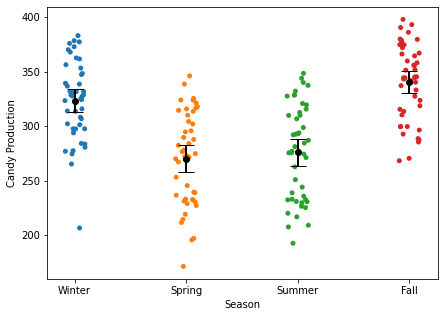

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))

# Jitter the data so we can see it all
sns.stripplot(data = season_sums, ax = ax, zorder = 0)

# Add confidence intervals
ax.errorbar(np.arange(4), season_means, yerr = season_CI, linestyle = '', 
           marker = 'o', linewidth = 2, capsize = 8, color = 'k')

# Could have also used below to add CIs more easily (in a more seaborn-y way) 
#sns.pointplot(data = season_sums, color = 'k', join = False)

ax.set(xlabel = 'Season', ylabel = 'Candy Production');

Is there a visible pattern of candy production by season? Are there any
other sensible ways to split up the data other than by season?


# Does candy production differ by season? ANOVA approach

One way to answer this question is by using One-way ANOVA on the data in `season_sums`



In [5]:
obs_fstatistic, p_val = scipy.stats.f_oneway(season_sums['Winter'], season_sums['Spring'], 
                                         season_sums['Summer'], season_sums['Fall'])
print(obs_fstatistic)
print(p_val)

35.24956033912304
5.694761280091359e-18


What does this suggest about our data? Are all seasons drawn from the same distribution?

# Does candy production differ by season? Permutation test


HINT: You want to shuffle all of the data as if you had misplaced all of
the season labels, but then reformat the data so that it looks like your
original data set (i.e. separated into four columns of 'fake' seasons),
then run the ANOVA to get the F-statistic

HINT: There are multiple ways to do this in Python - I used trusty numpy instead of pandas


In [6]:
n_perm = 1000

# Sample without replacement from these values, separate into fake
# seasons and perform the ANOVA again to get a distribution of F under H0

boot_fs = np.zeros((n_perm, ))
H0_data = season_sums.to_numpy().flatten()
for k in range(n_perm):

    # Shuffle the data
    np.random.shuffle(H0_data)
    
    #  Re-format into original shape (there may be an alternative approach that doesn't follow these steps)
    shuffled_data = H0_data.reshape((season_sums.shape))

    # Perform a 1-way ANOVA:
    fstatistic, p_val = scipy.stats.f_oneway(shuffled_data[:, 0], shuffled_data[:, 1], 
                                         shuffled_data[:, 2], shuffled_data[:, 3])
    
    # Save the f statistics
    boot_fs[k] = fstatistic

# Plot a distribution of the Fs we got under H0 


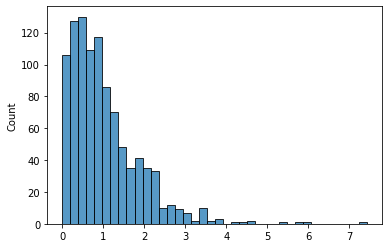

In [7]:
fig, ax = plt.subplots(1, 1)
sns.histplot(data = boot_fs, ax = ax)

# Compare your observed F-statistic to the permuted distribution


What is your p-value?


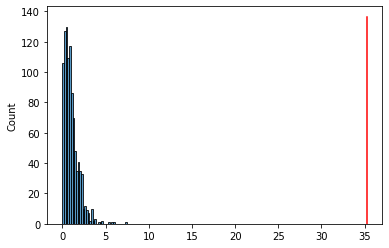

In [8]:
fig, ax = plt.subplots(1, 1)

sns.histplot(data = boot_fs, ax = ax)
ax.plot([obs_fstatistic, obs_fstatistic], ax.get_ylim(), 'r')

In [9]:
np.sum(boot_fs > obs_fstatistic) / n_perm

0.0

# Testing assumptions

1. Equal variances

In [10]:
bartlett_stat, p_val = scipy.stats.bartlett(season_sums['Summer'], season_sums['Fall'], season_sums['Winter'], season_sums['Spring'])
print(p_val)

0.31899549377351166


2. Normality of the residuals. What this is really trying to get at is 
that the distribution of Y|X is normal. In our data, we have a 
categorical predictor variable and a continuous dependent variable. 
Here residuals will have the same distribution as Y values in each group.
We can look at each group individually and assess each for normality.


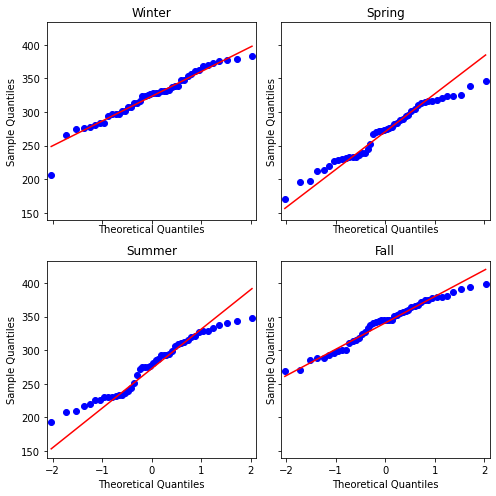

In [11]:
import statsmodels.api as sm

fig, axes = plt.subplots(2, 2, figsize = (7, 7), sharex = True, sharey = True)

axes = axes.flatten()

for i, season in enumerate(season_sums.columns):
  sm.graphics.qqplot(season_sums[season],  line = 'q', ax = axes[i])
  axes[i].set(title = season)

plt.tight_layout()
plt.show()

Is Y|X normally distributed for all seasons? If not, what can we do about it?

# Alternatively, we can look at all residuals together


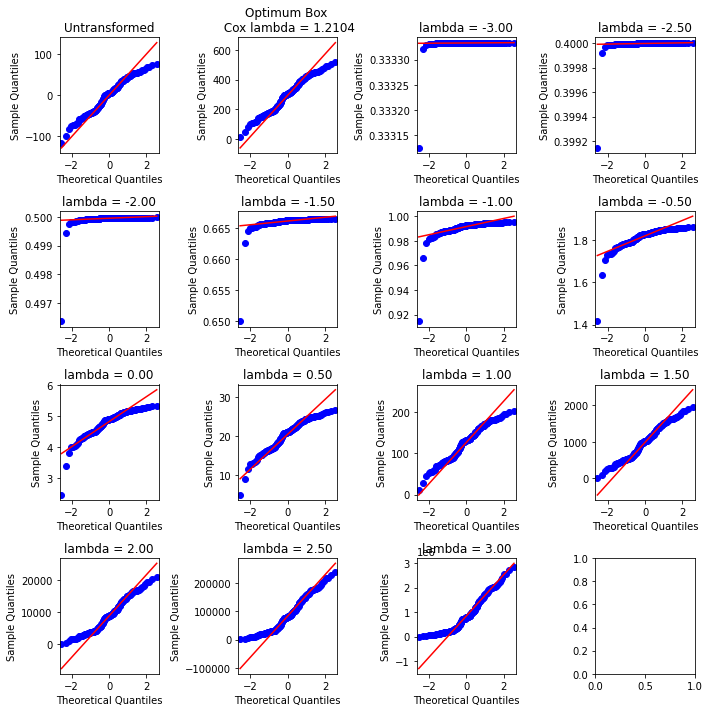

In [12]:
fig, axes = plt.subplots(4, 4, figsize = (10, 10))
axes = axes.flatten()

# Mean subtract from each season then flatten
all_resid = (season_sums - season_sums.mean()).to_numpy().flatten()
sm.graphics.qqplot(all_resid,  line = 'q', ax = axes[0])
axes[0].set(title = 'Untransformed')

# Transform our data (all residuals)
# For box cox transformations, our data have to all be positive
all_resid = all_resid + np.abs(all_resid.min()) + 0.1*np.abs(all_resid.min()) 
all_resid_opt, lmbda = scipy.stats.boxcox(all_resid)

sm.graphics.qqplot(all_resid_opt,  line = 'q', ax = axes[1])
axes[1].set(title = f'Optimum Box \n Cox lambda = {lmbda:.4f}')

lmbdas = np.arange(-3, 3.1, .5)
for i, lmbda in enumerate(lmbdas):
   all_resid_y  = scipy.stats.boxcox(all_resid, lmbda)
   sm.graphics.qqplot(all_resid_y,  line = 'q', ax = axes[i + 2])
   axes[i + 2].set(title = f'lambda = {lmbda:.2f}')

plt.tight_layout()
plt.show()

# Transform our data (by season)


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  scale = np.sqrt(((data - loc)**2).mean())
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  scale = np.sqrt(((data - loc)**2).mean())


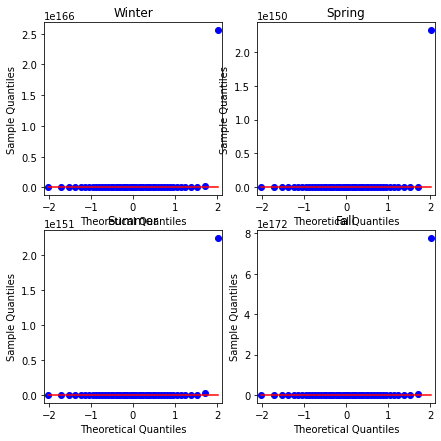

In [13]:
season_sums_T = 1 / season_sums
season_sums_T = np.exp(season_sums)

fig, axes = plt.subplots(2, 2, figsize = (7, 7))
axes = axes.flatten()

for i, season in enumerate(season_sums_T.columns):
    sm.graphics.qqplot(season_sums_T[season],  line = 'q', ax = axes[i])
    axes[i].set(title = season)